In [1]:
#import data using ccxt for live data
import ccxt
import pandas as pd
#assign the exchange to be binance in this case
exchange = ccxt.binance()
#this lets us easily change the conditions for fetching data
symbol = "BTC/USDT"
timeframe = '1h'
limit = 500
#fetch the recent OHLCV candles
ohlcv = exchange.fetch_ohlcv(symbol, timeframe = timeframe , limit=limit)

#create a pandas data frame for easy data manipulation
df = pd.DataFrame(ohlcv, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume'])
#change the timestamp to a readable time
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
#change timestamp column as the index of the dataframe
df.set_index('timestamp', inplace = True)#inplace modifies the df

print(df.head())

#next we calculate EMA- Exponential Moving Average
ema_period = 20 #short term 
df['EMA_20'] = df['close'].ewm(span=ema_period, adjust = False).mean()#using pd we can calutlate ema


#next we create a function to generate signals that takes df is input(trend - following logic)
def generate_signals(df):
    '''This function generates signals based on trend following logic.
    When price is above EMA we buy assuming the price follows the upward trend.
    When price is below EMA we sell assuming the price follows the downward trend.
    When there is no crossover, we hold.

    '''
    signals = [] #an empty list to store signals
    
    for i in range(len(df)):# this loops through the dataframe
        if i == 0 :
            signals.append('HOLD')#this deals with the first row as it has no previous value
        #generates buy signal
        elif df['close'].iloc[i] > df['EMA_20'].iloc[i] and df['close'].iloc[i-1] <= df['EMA_20'].iloc[i-1]:
            signals.append("BUY")
        #generates sell signal
        elif df['close'].iloc[i] < df['EMA_20'].iloc[i] and df['close'].iloc[i-1] >= df['EMA_20'].iloc[i-1]:
            signals.append("SELL")
        #hold if there is no crosover
        else:
            signals.append("HOLD")
    df['signal'] = signals #add signals to df
            

                          open       high        low      close     volume
timestamp                                                                 
2025-08-07 20:00:00  117461.99  117496.05  117140.32  117182.19  510.82309
2025-08-07 21:00:00  117182.19  117354.21  117012.00  117105.78  337.78727
2025-08-07 22:00:00  117105.77  117621.00  117079.39  117554.23  676.81999
2025-08-07 23:00:00  117554.23  117579.98  117292.88  117472.01  278.79062
2025-08-08 00:00:00  117472.02  117630.00  116870.21  117264.12  806.35514


In [2]:
generate_signals(df)
print(df[['close','EMA_20','signal']].tail(20))

                         close         EMA_20 signal
timestamp                                           
2025-08-27 20:00:00  112419.07  111613.492308   HOLD
2025-08-27 21:00:00  111528.19  111605.368279   SELL
2025-08-27 22:00:00  111409.54  111586.717966   HOLD
2025-08-27 23:00:00  111262.01  111555.793398   HOLD
2025-08-28 00:00:00  111338.92  111535.138789   HOLD
2025-08-28 01:00:00  111647.70  111545.858904    BUY
2025-08-28 02:00:00  111500.00  111541.491389   SELL
2025-08-28 03:00:00  112000.01  111585.159829    BUY
2025-08-28 04:00:00  112965.90  111716.658892   HOLD
2025-08-28 05:00:00  112853.24  111824.904712   HOLD
2025-08-28 06:00:00  113213.78  111957.178549   HOLD
2025-08-28 07:00:00  113114.11  112067.362497   HOLD
2025-08-28 08:00:00  113128.49  112168.422259   HOLD
2025-08-28 09:00:00  112856.89  112233.990615   HOLD
2025-08-28 10:00:00  113127.53  112319.089604   HOLD
2025-08-28 11:00:00  112909.18  112375.288690   HOLD
2025-08-28 12:00:00  113239.44  112457.588814 

In [3]:
def backtest(df, starting_capital=1000):
    capital = starting_capital  # starting cash in USD
    position = 0  # BTC amount currently held

    for i in range(len(df)):
        price = df['close'].iloc[i]

        # BUY signal
        if df['signal'].iloc[i] == "BUY" and position == 0:
            position = capital / price  # buy BTC with all cash
            capital = 0

        # SELL signal
        elif df['signal'].iloc[i] == "SELL" and position > 0:
            capital = position * price  # sell all BTC for cash
            position = 0

    # If still holding BTC at the end, convert to cash
    if position > 0:
        capital = position * df['close'].iloc[-1]

    return capital


In [4]:
final_capital = backtest(df, starting_capital=1000)
print("Final capital after backtest:", final_capital)

Final capital after backtest: 976.3372573806112


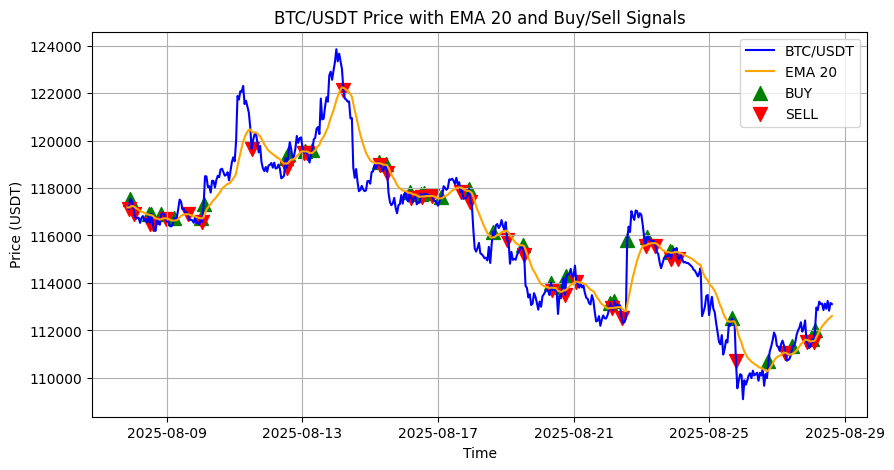

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(df['close'], label='BTC/USDT', color='blue')
plt.plot(df['EMA_20'], label='EMA 20', color='orange')

# Plot BUY signals
buy_signals = df[df['signal'] == 'BUY']
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='BUY', s=100)

# Plot SELL signals
sell_signals = df[df['signal'] == 'SELL']
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='SELL', s=100)

plt.title('BTC/USDT Price with EMA 20 and Buy/Sell Signals')
plt.xlabel('Time')
plt.ylabel('Price (USDT)')
plt.legend()
plt.grid(True)
plt.savefig("screenshot.png", dpi=75, bbox_inches='tight')
plt.show()